In [1]:
from collections import defaultdict, deque
from gymnasium.wrappers import Autoreset
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import random
import wandb
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, n_in, n_out, max_action):
        super().__init__()
        self.max_action = torch.tensor(max_action)
        self.fc1 = nn.Linear(n_in, 64)
        self.fc2 = nn.Linear(64, 64)
        self.g1 = nn.SiLU()
        self.g2 = nn.SiLU()
        self.value_head = nn.Linear(64, 1)
        self.mean_head = nn.Linear(64, n_out)
        self.log_std_head = nn.Linear(64, n_out)
        nn.init.zeros_(self.log_std_head.weight)  # start std off at 1.
        nn.init.zeros_(self.log_std_head.bias)

    def value_only(self, x):
        x = self.g1(self.fc1(x))
        x = self.g2(self.fc2(x))
        value = self.value_head(x)
        return value
        
    def forward(self, x):
        log_std_radius = 10  # log_std bounded by [-r, r]
        
        x = self.g1(self.fc1(x))
        x = self.g2(self.fc2(x))
        value = self.value_head(x)
        mean = self.mean_head(x)
        log_std = self.log_std_head(x)
        log_std = torch.tanh(log_std) * log_std_radius  # [-1, 1] * radius
        
        return value, mean, log_std

    def sample(self, state, stochastic=True):
        value, mean, log_std = self.forward(state)
        if stochastic:
            std = log_std.exp()
            normal = Normal(mean, std)
            x_t = normal.rsample()  # rsample does reparameterization trick, so we can backprop
            action = torch.tanh(x_t)
            log_prob = normal.log_prob(x_t)
            log_prob -= 2 * (torch.log(torch.tensor(2.0)) - x_t - F.softplus(-2 * x_t))  # <-- tanh derivative rewritten for numerical stability
        else:
            action = mean
            log_prob = torch.zeros_like(action)
        action *= self.max_action
            
        assert action.shape == log_prob.shape
        return action, log_prob, value

In [6]:
env_name = 'Pendulum-v1'
def make_env(render_mode=None):
    env = gym.make(env_name, render_mode=render_mode)
    env = Autoreset(env)
    return env

In [8]:
env = make_env()

In [10]:
@torch.no_grad()
def collect_rollout(env, network: ActorCritic, min_steps):
    states, actions, rewards, terminateds, log_probs, values = [], [], [], [], [], []
    state = torch.as_tensor(env.reset()[0])
    step = 0
    while True:
        step += 1
        action, log_prob, value = network.sample(state)
        next_state, reward, terminated, truncated, _ = env.step(action.numpy())
        next_state = torch.as_tensor(next_state)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        terminateds.append(terminated)
        log_probs.append(log_prob)
        values.append(value)
        state = next_state
        if step >= min_steps and (terminated or truncated):
            break
    values.append(network.value_only(state))  # add the last value, we now have T+1 values in total
        
    states = torch.stack(states)                                                  # [T, |s|], |s| = dimension of the state vector
    actions = torch.stack(actions).reshape(step, -1)                              # [T, |a|], |a| = dimension of the action vector
    rewards = torch.as_tensor(rewards).reshape(-1, 1)                             # [T, 1]
    terminateds = torch.as_tensor(terminateds, dtype=torch.float).reshape(-1, 1)  # [T, 1]
    log_probs = torch.stack(log_probs).reshape(step, -1)                          # [T, |a|], we need 1 normal dist for each action
    values = torch.stack(values)                                                  # [T+1, 1], T = num_steps
    
    return states, actions, rewards, terminateds, log_probs, values

In [11]:
@torch.no_grad()
def evaluate(network: ActorCritic, stochastic=False, render_mode=None, graph=False):
    _env = make_env(render_mode)
    state = torch.as_tensor(_env.reset()[0])
    sum_rewards = 0
    if graph:
        values = []
        immediate_reward = []
        rewards_collected = []
        values_plus_rewards = []
    step = 0
    while True:
        step += 1
        action, log_prob, value = network.sample(state, stochastic=stochastic)
        next_state, reward, terminated, truncated, _ = _env.step(action.numpy())
        sum_rewards += reward
        if graph:
            values += [value.item()]
            immediate_reward += [reward]
            rewards_collected += [sum_rewards]
            values_plus_rewards += [value.item() + sum_rewards]
            if step % 20 == 0 or terminated or truncated:
                plt.plot(values, label='values')
                plt.plot(immediate_reward, label='immediate reward')
                plt.plot(rewards_collected, label='rewards collected')
                plt.plot(values_plus_rewards, label='rewards + values')
                plt.legend()
                clear_output(wait=True)
                plt.show()
        state = torch.as_tensor(next_state)
        if terminated or truncated:
            break
    _env.close()
    return sum_rewards

In [12]:
def gae(rewards, terminateds, values, gamma, lambda_):
    td_errors = rewards + gamma * values[1:] * (1 - terminateds) - values[:-1]  # TD-errors = TD-targets - V(s)
    advantages = torch.zeros_like(td_errors)
    advantage = 0
    for t in reversed(range(len(td_errors))):
        advantage = lambda_ * gamma * advantage * (1 - terminateds[t]) + td_errors[t]  # gamma is being applied twice to discount far away TD-errors
        advantages[t] = advantage                                                      # also note (1 - terminateds[t]) is absolutely critical
        
    return advantages  # [T, 1], once trained, advantages should be close to 0

In [13]:
def explained_variance(returns, values):  # measure of critic's accuracy: 0 = random guessing, 1 = perfect
    var_returns = torch.var(returns)
    var_residuals = torch.var(returns - values)
    if var_returns == 0: return 0.0 if var_residuals == 0 else -float('inf')
    return (1 - var_residuals / var_returns).item()

In [14]:
batch_size = 64
num_steps = 2048  # steps per rollout
num_epochs = 10   # epochs per iteration
gae_lambda = 0.95      # GAE(lambda): 0 is same as TD-error, 1 is same as Monte Carlo return
value_weight = 0.5     # weight of value loss (vs policy loss)
entropy_bonus = 0.01   # entropy regularization coefficient in loss, may need to manually adjust with reward scale
clip_eps = 0.2         # policy ratio clipping radius
gamma = 0.99
policy_lr = 3e-4
value_lr = 1e-3
backbone_lr = 1e-3  # lr for the shared backbone, OpenAI's Spinning Up implicity uses same lr as critic

eval_freq = 3

try: env.reset(), env.close()
except: pass
env = make_env()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high

network = ActorCritic(state_dim, action_dim, max_action)

shared_backbone_params = list(network.fc1.parameters()) + list(network.fc2.parameters()) + list(network.g1.parameters()) + list(network.g2.parameters())
policy_head_params = list(network.mean_head.parameters()) + list(network.log_std_head.parameters())
value_head_params = list(network.value_head.parameters())

optimizer = torch.optim.Adam([  # single optimizer, avoids ambiguity in lr of backbone that is present in Spinning Up
    {'params': policy_head_params, 'lr': policy_lr},
    {'params': value_head_params, 'lr': value_lr},
    {'params': shared_backbone_params, 'lr': backbone_lr},
])

wandb.finish()
wandb.init(
    project='PPO-' + env_name,
    name='w/ swish!',
    # mode='disabled',
    config={
        'batch_size': batch_size,
        'num_steps': num_steps,
        'num_epochs': num_epochs,
        'gae_lambda': gae_lambda,
        'value_weight': value_weight,
        'entropy_bonus': entropy_bonus,
        'clip_eps': clip_eps,
        'gamma': gamma,
        'policy_lr': policy_lr,
        'value_lr': value_lr,
        'backbone_lr': backbone_lr,
        'env_name': env_name,
    }
)

history = {'step_count': 0}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kchau (kchau-university-of-calgary-in-alberta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [21]:
num_steps = 100
states, actions, rewards, terminateds, log_probs, values = collect_rollout(env, network, num_steps) 
advantages = gae(rewards, terminateds, values, gamma, gae_lambda)
returns = values[:-1] + advantages  # discounted rewards-to-go
indices = torch.arange(num_steps)
for begin in range(0, num_steps, batch_size):
    end = begin + batch_size
    print(end)
    batch_indices = indices[begin:end]

    states_b = states[batch_indices]
    actions_b = actions[batch_indices]
    returns_b = returns[batch_indices]
    advantages_b = advantages[batch_indices]
    old_log_probs = log_probs[batch_indices]

values_b, means, log_stds = network(states_b)
dist = Normal(means, log_stds.exp())

cur_log_probs = dist.log_prob(actions_b)
# ratio = torch.exp(cur_log_probs - old_log_probs)
# advantages_b.shape
# ratio.shape
old_log_probs.shape
cur_log_probs.shape

64
128


torch.Size([36, 1])

In [160]:
state, _ = env.reset()
state = torch.as_tensor(state)
network(state)

(tensor([0.0101], grad_fn=<ViewBackward0>),
 tensor([ 0.0606, -0.0605], grad_fn=<ViewBackward0>),
 tensor([0., 0.], grad_fn=<MulBackward0>))

In [71]:
def train(env, num_updates, history):
    t_start = time.time()
    for update in range(1, num_updates+1):
        t0 = time.time()
        states, actions, rewards, terminateds, log_probs, values = collect_rollout(env, network, num_steps) 
        advantages = gae(rewards, terminateds, values, gamma, gae_lambda)
        returns = values[:-1] + advantages  # discounted rewards-to-go
        actual_steps = len(states)  # actual steps taken 
        for _ in range(num_epochs):
            indices = torch.randperm(actual_steps)
            for begin in range(0, actual_steps, batch_size):
                end = begin + batch_size
                batch_indices = indices[begin:end]
                
                states_b = states[batch_indices]
                actions_b = actions[batch_indices]
                returns_b = returns[batch_indices]
                advantages_b = advantages[batch_indices]
                old_log_probs = log_probs[batch_indices]
                
                logits, values_b = network(states_b)
                dist = Categorical(logits=logits)
                entropy = dist.entropy().mean()
                cur_log_probs = dist.log_prob(actions_b.squeeze()).reshape(old_log_probs.shape)
            
                # policy loss
                ratio = torch.exp(cur_log_probs - old_log_probs)  # same as cur_probs/old_probs, just with logs
                fst_surrogate = ratio * advantages_b
                snd_surrogate = torch.clip(ratio, 1 - clip_eps, 1 + clip_eps) * advantages_b
                policy_loss = -torch.min(fst_surrogate, snd_surrogate).mean() - entropy_bonus * entropy
                
                # value loss
                value_loss = F.mse_loss(values_b, returns_b, reduction='mean') * value_weight

                cum_loss = policy_loss + value_loss
                optimizer.zero_grad()
                cum_loss.backward()
                optimizer.step()
        history['step_count'] += actual_steps
        
        update_time = time.time() - t0
        wall_time = time.time() - t_start

        with torch.no_grad():
            exp_var = explained_variance(returns, values[:-1])
            approx_kl = (old_log_probs - cur_log_probs).mean().item()  # 1st order approximation

        log = {
            'update': update,
            'step_count': history['step_count'],
            'wall_time': wall_time,
            'update_time': update_time,
            'advantage': advantages.mean().item(),
            'entropy': entropy.item(),
            'explained_variance': exp_var,
            'approx_kl': approx_kl,
        }

        if update % eval_freq == 0 or update == num_updates:
            t0 = time.time()
            eval_rewards = evaluate(network)
            eval_time = time.time() - t0
            log.update({
                'eval_time': eval_time,
                'eval_rewards': eval_rewards,
            })

            clear_output(wait=True)
            print(f'wall time {wall_time:.2f} s')
            print(f'update {update}')
            print(f'step {history["step_count"]}')
            print(f'eval return {eval_rewards:.5f}')

        try: wandb.log(log)
        except: print(f'[warning] wandb log failed')

In [73]:
t0 = time.time()
try:
    train(env, 50, history)
except KeyboardInterrupt:
    print('keyboard interrupt. stopping...')
finally:
    print(f'done.\n*actual* time taken: {time.time() - t0:.2f} s')

wall time 223.41 s
update 50
step 204800
eval return 500.00000
done.
*actual* time taken: 223.89 s


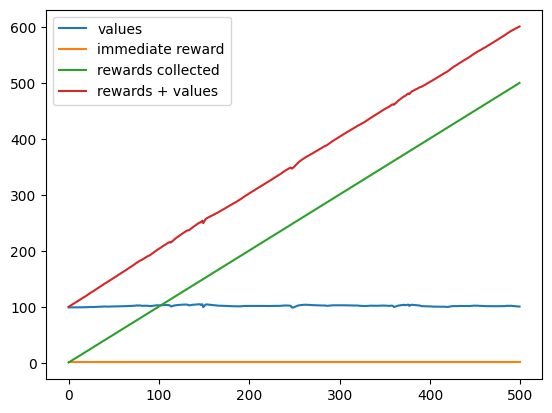

500.0

In [74]:
evaluate(network, stochastic=True, render_mode='human', graph=True)

In [75]:
print(list(network.g1.parameters()))  # for prelu
print(list(network.g2.parameters()))

[]
[]


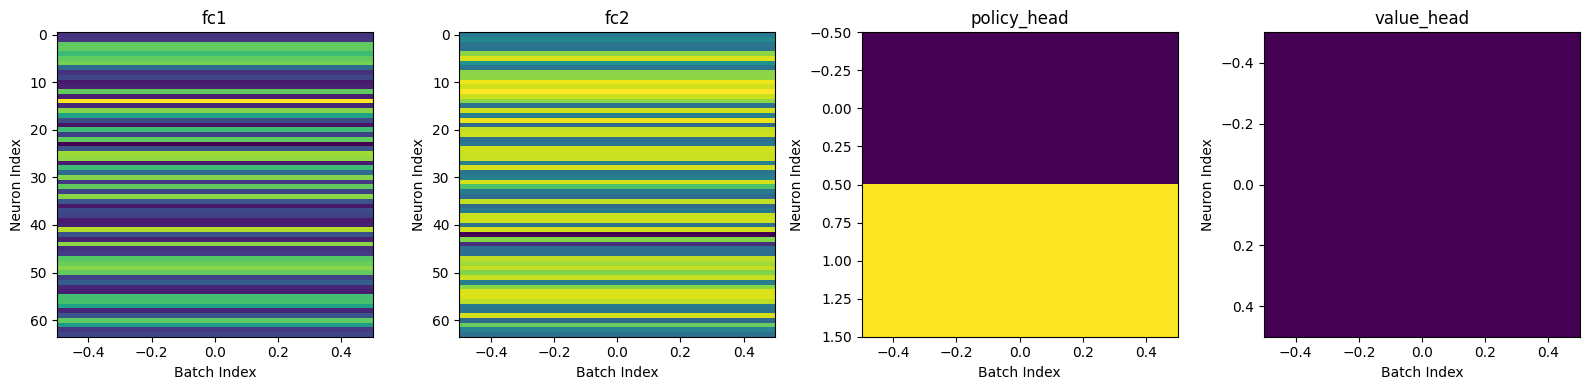

fc1 [-0.552763   -0.52349865  0.7410354   0.7568286   0.60381603  0.7459245
  0.826619   -0.11631504 -0.5443609  -0.40916455 -0.69503987 -0.6564159
  0.7487649  -0.6648636   1.2660403  -0.6040347   0.8849282   0.36523056
 -0.35934478 -0.7334785   0.6165218  -0.44305593  0.75079954 -0.8515429
 -0.31315646  0.96272635  0.9227844  -0.68455523  0.6038405  -0.10936819
  0.8826949  -0.49052405  0.74768025 -0.4353761   0.8907737  -0.29700062
 -0.7058539  -0.37352332 -0.43198162 -0.6876314  -0.6662407   1.0242432
 -0.31309554 -0.6390803   0.89447623 -0.5637202  -0.4807899   0.7127922
  0.78826404  0.88981533  0.75324386 -0.448233   -0.22872543 -0.617108
 -0.67915416  0.6238027   0.65205896  0.37217045 -0.6330074  -0.2909698
  0.7523092   0.3151616  -0.50407267 -0.3976528 ]
fc2 [ -3.8203514  -2.2464175  -4.3339624  -4.4692435   5.547409    8.201872
  -1.4590513  -4.4474277   5.55406     5.6771708   8.853319    7.8144636
   9.417504    7.627388    5.5396333  -4.48308     7.83626    -3.4139454
  

In [76]:
def plot_activations(model, x, print_=True):
    activations = {}
    def hook_fn(module, inp, out, name):
        activations[name] = out.detach().cpu().numpy()
    hooks = []
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.Linear):  # capture only linear layers
            hooks.append(layer.register_forward_hook(lambda m, inp, out, n=name: hook_fn(m, inp, out, n)))
    with torch.no_grad():
        model(x)
    for hook in hooks:
        hook.remove()
    num_plots = len(activations)
    fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))
    if num_plots == 1:
        axes = [axes]
    sout = ''
    for ax, (name, act) in zip(axes, activations.items()):
        sout += name + ' ' + str(act) + '\n'
        if act.ndim == 1:
            act = act.reshape(1, -1)
        ax.imshow(act.T, aspect='auto', cmap='viridis')
        ax.set_title(name)
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Neuron Index')
    plt.tight_layout()
    plt.show()
    if print_: print(sout)

state, _ = env.reset()
state = torch.as_tensor(state)
plot_activations(network, torch.as_tensor(state))

In [77]:
import os
os.makedirs('./saved', exist_ok=True)
torch.save(network.state_dict(), f'./saved/{env_name}-actor-critic.pth')
print('saved.')

saved.
